Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

In [5]:
import numpy as np
import torch

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [7]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [4]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [72]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """
        self.output = input

        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, the module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        m_num = len(self.modules)-1
        for i in range(m_num):
            gradOutput = self.modules[m_num-i].backward(self.modules[m_num-i-1].output, gradOutput)

        self.gradInput = self.modules[0].backward(input, gradOutput)
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

In [78]:
import torch
import torch.nn as nn
import numpy as np

# Create a random input tensor and gradient output tensor
input_tensor = torch.randn(10, 5, requires_grad=True)
grad_output_tensor = torch.randn(10, 3)

# Create an instance of the provided Sequential container
sequential_container = Sequential()

# Create an instance of the PyTorch nn.Sequential container
torch_sequential_container = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 3)
)

# Add modules to the provided Sequential container
sequential_container.add(Linear(5, 10))
sequential_container.add(ReLU())
sequential_container.add(Linear(10, 3))

# Set the weights and biases of the provided Sequential container to match the PyTorch nn.Sequential container
for i, (module, torch_module) in enumerate(zip(sequential_container.modules, torch_sequential_container)):
    if isinstance(module, Linear):
        module.W = torch_module.weight.detach().numpy().T
        module.b = torch_module.bias.detach().numpy()

# Forward pass using the provided Sequential container
sequential_output = sequential_container.updateOutput(input_tensor.detach().numpy())

# Forward pass using the PyTorch nn.Sequential container
torch_sequential_output = torch_sequential_container(input_tensor)

# Set the gradient output to ones
grad_output = torch.ones_like(torch_sequential_output)

# Backward pass using the provided Sequential container
sequential_container.backward(input_tensor.detach().numpy(), grad_output.detach().numpy())

# Backward pass using the PyTorch nn.Sequential container
torch_sequential_output.backward(grad_output)

# Compare the outputs
output_diff = np.abs(sequential_output - torch_sequential_output.detach().numpy())
max_output_diff = np.max(output_diff)

# Compare the gradients
grad_input_diff = np.abs(sequential_container.gradInput - input_tensor.grad.numpy())
max_grad_input_diff = np.max(grad_input_diff)

# Check if the outputs and gradients are equal within a tolerance
if max_output_diff < 1e-6 and max_grad_input_diff < 1e-6:
    print("The outputs and gradients of the provided Sequential container and the PyTorch nn.Sequential container are equal.")
else:
    print("The outputs and gradients of the provided Sequential container and the PyTorch nn.Sequential container are not equal.")


Init W shape: (10, 5)
Init W shape: (3, 10)
input shape: (10, 5) W inside shape: (5, 10) B shape: (10,)
Out shape: (10, 10)
input shape: (10, 10) W inside shape: (10, 3) B shape: (3,)
Out shape: (10, 3)
input shape: (10, 10) gradOutput shape: (10, 3) W.shape: (10, 3)
GradInput shape: (10, 10)
input shape: (10, 5) gradOutput shape: (10, 10) W.shape: (5, 10)
GradInput shape: (10, 5)
The outputs and gradients of the provided Sequential container and the PyTorch nn.Sequential container are equal.


# Layers

## 1. Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [64]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        print('Init W shape:' , self.W.shape)
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = ...
        print('input shape:', input.shape, 'W inside shape:' , self.W.shape, 'B shape:', self.b.shape) # self.W somehow has swapped dimensions...
        self.output = input@self.W + self.b
        print('Out shape:', self.output.shape)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        print('input shape:', input.shape, 'gradOutput shape:', gradOutput.shape, 'W.shape:', self.W.shape)
        self.gradInput = gradOutput@self.W.T
        print('GradInput shape:', self.gradInput.shape)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):  # BxD -> BxM
        # Your code goes here. ################################################
        self.gradb = gradOutput.sum(0)      # BxM -> 1xM
        self.gradW = input.T@gradOutput     # DxB x BxM = DxM
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [65]:
import torch
import numpy as np

# Create a random input tensor
input_tensor = torch.randn(10, 5, requires_grad=True)

# Create an instance of the provided Linear module
linear_module = Linear(5, 3)

# Create an instance of the PyTorch nn.Linear module with the same dimensions
torch_linear_module = torch.nn.Linear(5, 3)

# Set the weights and biases of the provided Linear module to match the PyTorch nn.Linear module
linear_module.W = torch_linear_module.weight.detach().numpy().T
linear_module.b = torch_linear_module.bias.detach().numpy()

# Forward pass using the provided Linear module
linear_output = linear_module.updateOutput(input_tensor.detach().numpy())

# Forward pass using the PyTorch nn.Linear module
torch_linear_output = torch_linear_module(input_tensor)

# Set the gradient output to ones
grad_output = torch.ones_like(torch_linear_output)

# Backward pass using the provided Linear module
linear_module.updateGradInput(input_tensor.detach().numpy(), grad_output.detach().numpy())
linear_module.accGradParameters(input_tensor.detach().numpy(), grad_output.detach().numpy())

# Backward pass using the PyTorch nn.Linear module
torch_linear_output.backward(grad_output)
torch_grad_input = input_tensor.grad
torch_grad_W = torch_linear_module.weight.grad.T.detach().numpy()
torch_grad_b = torch_linear_module.bias.grad.detach().numpy()

# Compare the gradients
grad_input_diff = np.abs(linear_module.gradInput - torch_grad_input.numpy())
grad_W_diff = np.abs(linear_module.gradW - torch_grad_W)
grad_b_diff = np.abs(linear_module.gradb - torch_grad_b)
max_grad_input_diff = np.max(grad_input_diff)
max_grad_W_diff = np.max(grad_W_diff)
max_grad_b_diff = np.max(grad_b_diff)

# Check if the gradients are equal within a tolerance
if max_grad_input_diff < 1e-6 and max_grad_W_diff < 1e-6 and max_grad_b_diff < 1e-6:
    print("The gradients of the provided Linear module and the PyTorch nn.Linear module are equal.")
else:
    print("The gradients of the provided Linear module and the PyTorch nn.Linear module are not equal.")


Init W shape: (3, 5)
input shape: (10, 5) W inside shape: (5, 3) B shape: (3,)
Out shape: (10, 3)
input shape: (10, 5) gradOutput shape: (10, 3) W.shape: (5, 3)
GradInput shape: (10, 5)
The gradients of the provided Linear module and the PyTorch nn.Linear module are equal.


## 2. SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [171]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        input_exp = np.exp(np.subtract(input, input.max(axis=1, keepdims=True)))
        # print((np.exp(input).sum(axis=1)**-1).shape)
        self.output = input_exp * input_exp.sum(axis=1, keepdims=True)**-1
        # Your code goes here. ################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = (gradOutput - (gradOutput * self.output).sum(axis=1, keepdims=True)) * self.output
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

In [151]:
import numpy as np
import torch

# Sample input
input_data = np.array([[1, 2, 3], [4, 5, 6]])

# Softmax using the provided implementation
output_custom = softmax_custom.updateOutput(input_data)


# Softmax using torch
input_torch = torch.from_numpy(input_data).float()  # Convert to float data type
output_torch = torch.softmax(input_torch, dim=1)
grad_output_torch = torch.ones_like(output_torch)  # Dummy gradient for demonstration
grad_input_torch = grad_output_torch * (output_torch * (1 - output_torch))

# Compare outputs
print("Custom Softmax output:")
print(output_custom)
print("Torch Softmax output:")
print(output_torch.numpy())

# Compare gradients
print("Custom Softmax gradient:")
print(grad_input_custom)
print("Torch Softmax gradient:")
print(grad_input_torch.numpy())


Custom Softmax output:
[[0.09003057 0.24472847 0.66524096]
 [0.09003057 0.24472847 0.66524096]]
Torch Softmax output:
[[0.09003057 0.24472848 0.66524094]
 [0.09003057 0.24472848 0.66524094]]
Custom Softmax gradient:
[[0.90996943 0.75527153 0.33475904]
 [0.90996943 0.75527153 0.33475904]]
Torch Softmax gradient:
[[0.08192507 0.18483646 0.22269543]
 [0.08192507 0.18483646 0.22269543]]


In [170]:
import torch

input_data = np.array([[1, 2, 3], [4, 5, 6]])
output_grad=np.ones_like(input_data)
# Convert our random data into pytorch tensors.
torch_input = torch.tensor(input_data, requires_grad=True, dtype=float)
torch_output_grad = torch.from_numpy(output_grad)


softmax_custom = SoftMax()
output_custom = softmax_custom.updateOutput(input_data)
grad_output_custom = np.ones_like(output_custom)  # Dummy gradient for demonstration
grad_input_custom = softmax_custom.updateGradInput(input_data, grad_output_custom)

# Compute softmax (retain grad to check the intermediate gradient).
torch_output = torch.softmax(torch_input, axis=1)
torch_output.retain_grad()

# Sum the output with the output_grad coefficients.
# This will make the gradient torch_output.grad be equal to output_grad.
loss = (torch_output * torch_output_grad).sum()
loss.backward()
assert np.allclose(torch_output.grad.detach().numpy(), output_grad)

# Now that we have correct output_grad, let's check the input gradient.
assert np.allclose(torch_input.grad.detach().numpy(), grad_input_custom)


## 3. LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [199]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        # Your code goes here. ################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        #self.gradInput = self.output - gradOutput
        if self.output is None: self.updateOutput(input)
        self.gradInput = gradOutput - np.exp(self.output) * np.sum(gradOutput, axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"


In [200]:
import torch

input_data = np.array([[1, 2, 3], [4, 5, 6]])
output_grad=np.ones_like(input_data)
# Convert our random data into pytorch tensors.
torch_input = torch.tensor(input_data, requires_grad=True, dtype=float)
torch_output_grad = torch.from_numpy(output_grad)


softmax_custom = LogSoftMax()
output_custom = softmax_custom.updateOutput(input_data)
grad_output_custom = np.ones_like(output_custom)  # Dummy gradient for demonstration
grad_input_custom = softmax_custom.updateGradInput(input_data, grad_output_custom)

# Compute softmax (retain grad to check the intermediate gradient).
torch_output = torch.log_softmax(torch_input, axis=1)
torch_output.retain_grad()

# Sum the output with the output_grad coefficients.
# This will make the gradient torch_output.grad be equal to output_grad.
loss = (torch_output * torch_output_grad).sum()
loss.backward()

print(grad_input_custom, torch_input.grad)


assert np.allclose(torch_output.grad.detach().numpy(), output_grad)

# Now that we have correct output_grad, let's check the input gradient.
assert np.allclose(torch_input.grad.detach().numpy(), grad_input_custom)


[[ 0.72990828  0.26581459 -0.99572287]
 [ 0.72990828  0.26581459 -0.99572287]] tensor([[ 0.7299,  0.2658, -0.9957],
        [ 0.7299,  0.2658, -0.9957]], dtype=torch.float64)


## 4. Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [35]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        N = input.shape[0]
        # training mode
        if self.training==True:
            self.b_mu = 1./N * np.sum(input, axis = 0, keepdims=True)
            self.b_diff = input - self.b_mu
            self.b_diffsq = self.b_diff**2
            self.b_var = 1./N * np.sum(self.b_diffsq, axis=0, keepdims=True)
            self.b_var_sqrt = np.sqrt(self.b_var + self.EPS)
            self.b_varsqrt_inv = 1./self.b_var_sqrt
            self.output = self.b_varsqrt_inv * self.b_diff
            # update statistics

            print(self.b_var, self.b_mu)
            self.moving_mean = self.moving_mean * self.alpha + self.b_mu * (1. - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.b_var * (1. - self.alpha)
        else:
            # inference mode
            self.output = (input - self.moving_mean) * 1./np.sqrt(self.moving_variance + self.EPS)

        return self.output

    def updateGradInput(self, input, gradOutput):
        #dx_norm == gradOutput
        db_varsqrt_inv = (gradOutput * self.b_diff).sum(axis=0,keepdims=True)
        db_diff1 = gradOutput * self.b_varsqrt_inv  # first graph edge that includes b_diff
        db_var_sqrt = db_varsqrt_inv * -1./self.b_var_sqrt**2
        db_var = 0.5 * 1. /self.b_var_sqrt
        db_diffsq = 1./input.shape[0] * np.ones_like(input) * db_var
        db_diff2 = 2*self.b_diff*db_diffsq  # second graph edge that includes b_diff
        d_input1 = db_diff1+db_diff2  # also one of the edges with input
        db_mu = -1*(db_diff1 + db_diff2).sum(axis=0)
        d_input2 = 1/input.shape[0] * np.ones_like(input) * db_mu  # second input edge
        self.gradInput = d_input1+d_input2  # summation of grads for two edges coming from the input

        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

[[0.14470355 1.26837181]] [[2.0128203  5.00191178]]


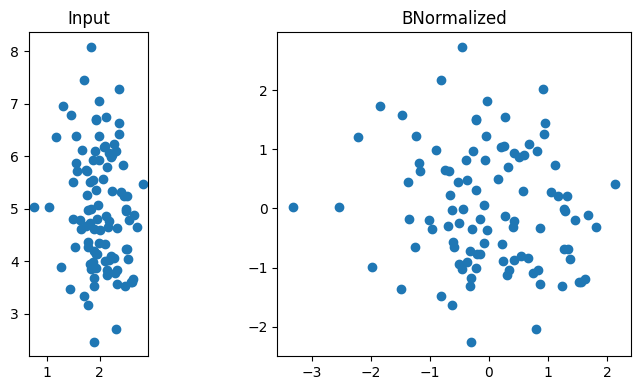

In [36]:
def a():
    import matplotlib.pyplot as plt

    N = 100  # Number of points
    mean = [2, 5]  # Mean of the distribution
    cov = [[0.2, 0], [0, 1.5]]  # Covariance matrix
    points = np.random.multivariate_normal(mean, cov, N)

    x,y = points[:,0], points[:,1]

    bm = BatchNormalization(alpha=0.01)
    bm.moving_mean = np.array([2, 5.01])
    bm.moving_variance = np.array([0.2, 122.5])

    points_bm = bm.updateOutput(points)
    x_bm = points_bm[:, 0]
    y_bm = points_bm[:, 1]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))  # Adjust the figsize to your preference

    ax1.scatter(x, y)
    ax1.set_title("Input")
    ax1.set_aspect('equal')  # Set aspect ratio to 'equal' for square shape

    ax2.scatter(x_bm, y_bm)
    ax2.set_title("BNormalized")
    ax2.set_aspect('equal')  # Set aspect ratio to 'equal' for square shape

    plt.tight_layout()
    plt.show()

In [38]:
def b():
    bm.backward(points, 1)
    mu = 1./N * np.sum(points_bm, axis = 0, keepdims=True)
    diff = points_bm - mu
    diff2 = diff**2
    var = 1./N * np.sum(diff2, axis=0, keepdims=True)

    mu, var


(array([[-1.78523862e-15, -2.61943245e-16]]),
 array([[0.99313675, 0.99921221]]))

In [39]:
def c():
    mu = 1./N * np.sum(points, axis = 0, keepdims=True)
    diff = points-mu
    diff2 = diff**2
    var = 1./N * np.sum(diff2, axis=0, keepdims=True)

    mu, var

(array([[2.0128203 , 5.00191178]]), array([[0.14470355, 1.26837181]]))

In [40]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

(array([0, 1, 1, 1, 0]),
 array([[0.        , 0.68730316, 0.18171111, 0.68425091, 0.        ],
        [0.        , 0.42656155, 0.85657482, 0.86598777, 0.        ],
        [0.        , 0.58514326, 0.2553581 , 0.67645844, 0.        ]]))

In [42]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training == True:
            self.mask = np.random.binomial(1, self.p, input.shape[-1])
            self.output = self.mask*input/(1 - self.p)
        else:
            self.output = input

        return  self.output

    def updateGradInput(self, input, gradOutput):  # NxD
        # Your code goes here. ################################################
        self.gradinput = self.mask*gradOutput  # NxD
        return self.gradInput

    def __repr__(self):
        return "Dropout"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [77]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 6. Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [44]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = max(self.slope*input, input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(x > 0, 1, self.slope) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 7. ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [45]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.max(input, self.alpha*(np.exp(input) -1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = input * np.exp(input) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 8. SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [46]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(1. + np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        1./(1. + np.exp(input)) * np.exp(input) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# Criterions

Criterions are used to score the models answers.

In [120]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [121]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 9. Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [135]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        self.output = -np.sum(np.log(3input_clamp[target.astype(bool)]))

        return self.output

    def updateGradInput(self, input, target):
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = np.zeros_like(input)
        self.gradInput[target.astype(bool)] = -1. / input_clamp[target.astype(bool)]

        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [134]:
input = np.array([1,2,3,4])
target = []

## 10. Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [129]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = -input[target.astype(bool)].sum()
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(input)
        self.gradInput[target.astype(bool)] = 1.
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

In [130]:
# Toy example
input = np.array([0.5, 0.2, 0.3])
target = np.array([False, True, False])

criterion = ClassNLLCriterion()
output = criterion.updateOutput(input, target)
gradInput = criterion.updateGradInput(input, target)

print("Output:", output)
print("GradInput:", gradInput)

Output: -0.2
GradInput: [0. 1. 0.]


# Optimizers

### SGD optimizer with momentum
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate` and `momentum`)
- `state` - dict with optimizator state (used to save accumulated gradients)

In [52]:
def sgd_momentum(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})

    var_index = 0
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):

            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))

            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)

            current_var -= old_grad
            var_index += 1

## 11. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer
- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$

In [53]:
def adam_optimizer(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()

    var_index = 0
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))

            # <YOUR CODE> #######################################
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            np.add(config['beta1'] * state['m'][state['t']-1], (1. - config['beta1']) * current_grad, out=var_first_moment)
            np.add(config['beta2'] * state['v'][state['t']-1], (1. - config['beta2']) * current_grad * current_grad, out=var_second_moment)
            current_var -= lr_t * var_first_moment / (np.sqrt(var_second_moment) + config['epsilon'])
            #np.add(... , out=var_first_moment)
            #np.add(... , out=var_second_moment)
            #current_var -= ...
            state['t'] += 1
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1


# Layers for advanced track homework
You **don't need** to implement it if you are working on `homework_main-basic.ipynb`

## 12. Conv2d [Advanced]
- input:   **`batch_size x in_channels x h x w`**
- output: **`batch_size x out_channels x h x w`**

You should implement something like pytorch `Conv2d` layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.

Practical notes:
- While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch) implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory. So **don't use** `scipy.signal.convolve` since it implements [convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution) in terms of signal processing.
- It may be convenient to use `skimage.util.pad` for zero-padding.
- It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension
- Having troubles with understanding how to implement the layer?
 - Check the last year video of lecture 3 (starting from ~1:14:20)
 - May the google be with you

In [54]:
import scipy.signal


In [ ]:
def d():
    conv = torch.nn.Conv2d(
        in_channels=1,
        out_channels=1,
        kernel_size=3,
        bias=False,
        stride = 1,
        padding_mode='zeros',
        padding=0
    )

    xt = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]], dtype=torch.float32)
    wt = torch.tensor([[[[1, 2, 3], [4, 5, 6], [7, 8, 9]]]], dtype=torch.float32)

    xt.requires_grad = True
    conv.weight = torch.nn.Parameter(w)
    out = conv(x)

    x = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
    w = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
    out2 = correlate(x, w, mode='valid')

    x = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
    w = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
    out2 = correlate(x, w, mode='valid')
    out, out2

In [204]:
  import scipy as sp
  import scipy.signal
  import skimage

  class Conv2d(Module):
      def __init__(self, in_channels, out_channels, kernel_size):
          super(Conv2d, self).__init__()
          assert kernel_size % 2 == 1, kernel_size

          stdv = 1./np.sqrt(in_channels)
          self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size)) # out_channels = filters num
          self.b = np.random.uniform(-stdv, stdv, size=(out_channels,)) # one bias term per filter
          self.in_channels = in_channels
          self.out_channels = out_channels
          self.kernel_size = kernel_size

          self.gradW = np.zeros_like(self.W)
          self.gradb = np.zeros_like(self.b)

      def updateOutput(self, input):
          pad_size = self.kernel_size // 2
          # YOUR CODE ##############################
          padded_input = np.pad(input, ((0,0),(0,0),(pad_size,pad_size), (pad_size,pad_size))) # pad only spacial dimensions
          # print(f'input:{input.shape}, W:{self.W.shape}, padded:{padded_input.shape}')
          # print(padded_input)
          self.output = scipy.signal.correlate(padded_input, self.W , mode='valid') # if it was a CORRELATION func then we would NOT rotate W by 180 degrees
          self.output = self.output+self.b
          print(f'out:{self.output.shape}')
          # 1. zero-pad the input array
          # 2. compute convolution using scipy.signal.correlate(... , mode='valid')
          # 3. add bias value
          # self.output = ...

          return self.output

      def updateGradInput(self, input, gradOutput):
          pad_size = self.kernel_size // 2
          # YOUR CODE ##############################
          # 1. zero-pad the gradOutput
          padded_gradOutput = np.pad(gradOutput, pad_size)
          # 2. compute 'self.gradInput' value using scipy.signal.correlate(... , mode='valid')
          self.gradInput = scipy.signal.correlate(padded_gradOutput, self.W , mode='valid')  # if it was a CORRELATION func then we WOULD rotate W by 180 degrees
          return self.gradInput

      def accGradParameters(self, input, gradOutput):
          pad_size = self.kernel_size // 2
          # YOUR CODE #############
          padded_input = np.pad(input, ((0,0),(0,0),(pad_size,pad_size), (pad_size,pad_size))) # pad only spacial dimensions

          self.gradW = scipy.signal.correlate(padded_input, gradOutput, mode='valid')
          print(gradOutput.shape)
          print("COMPUTING GRADBBB!")
          print(gradOutput, gradOutput.shape)
          self.gradb = gradOutput.sum(axis=(2,3))
          # 1. zero-pad the input
          # 2. compute 'self.gradW' using scipy.signal.correlate(... , mode='valid')
          # 3. compute 'self.gradb' - formulas like in Linear of ChannelwiseScaling layers
          pass

      def zeroGradParameters(self):
          self.gradW.fill(0)
          self.gradb.fill(0)

      def getParameters(self):
          return [self.W, self.b]

      def getGradParameters(self):
          return [self.gradW, self.gradb]

      def __repr__(self):
          s = self.W.shape
          q = 'Conv2d %d -> %d' %(s[1],s[0])
          return q

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [203]:
def d():
    toy_input = np.array([[[[1, 2, 3],
                          [4, 5, 6],
                          [7, 8, 9]]]])
    toy_weights = np.array([[[[1, 5, 5],
                          [1, 1, 6],
                          [7, 1, 1]]]])

    toy_input_torch = torch.tensor(toy_input, dtype=torch.float32)
    toy_weight_torch =  torch.tensor(toy_weights, dtype=torch.float32)

    handmade_conv = Conv2d(in_channels=1, out_channels=1, kernel_size=3)
    handmade_conv.W = toy_weights
    handmade_output = handmade_conv.updateOutput(toy_input)
    hg = handmade_conv.backward(toy_input, np.ones_like(handmade_output))


    torch_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=(3 - 1) // 2)  # Adjust padding to match output size
    torch_conv.weight.data = toy_weight_torch
    torch_output = torch_conv(toy_input_torch)
    torch_output.backward(torch.ones_like(torch_output))
    tg = torch_conv.weight.grad

    #handmade_output, torch_output, handmade_conv.gradW, tg
    handmade_conv.gradb, torch_conv.bias.grad

out:(1, 1, 3, 3)
(1, 1, 3, 3)
COMPUTING GRADBBB!
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]] (1, 1, 3, 3)


(array([[9.]]), tensor([9.]))

## 13. MaxPool2d [Advanced]
- input:   **`batch_size x n_input_channels x h x w`**
- output: **`batch_size x n_output_channels x h // kern_size x w // kern_size`**

You are to implement simplified version of pytorch `MaxPool2d` layer with stride = kernel_size. Please note, that it's not a common case that stride = kernel_size: in AlexNet and ResNet kernel_size for max-pooling was set to 3, while stride was set to 2. We introduce this restriction to make implementation simplier.

Practical notes:
- During forward pass what you need to do is just to reshape the input tensor to `[n, c, h / kern_size, kern_size, w / kern_size, kern_size]`, swap two axes and take maximums over the last two dimensions. Reshape + axes swap is sometimes called space-to-batch transform.
- During backward pass you need to place the gradients in positions of maximal values taken during the forward pass
- In real frameworks the indices of maximums are stored in memory during the forward pass. It is cheaper than to keep the layer input in memory and recompute the maximums.

In [112]:
class MaxPool2d(Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.gradInput = None
        # no stride because it woluld require a different implementation that reshaping due to overlaps

    def updateOutput(self, input):
        input_h, input_w = input.shape[-2:]
        # your may remove these asserts and implement MaxPool2d with padding
        #assert input_h % self.kernel_size == 0
        #assert input_w % self.kernel_size == 0
        # Reshape the input tensor
        ip = input
        hpad_size, wpad_size = 0, 0
        # check the sizes match
        if input_h % self.kernel_size != 0:
            hpad_size = ((self.kernel_size - input_h % self.kernel_size) % self.kernel_size)//2
        if input_w % self.kernel_size != 0:
            wpad_size = ((self.kernel_size - input_w % self.kernel_size) % self.kernel_size)//2

        print(hpad_size, wpad_size)

        if hpad_size or hpad_size:
            input = np.pad(input, ((0,0), (0,0), (hpad_size,hpad_size), (wpad_size,wpad_size)))
        # new padded h and w
        pad_input_h, pad_input_w = input.shape[-2:]
        # reshape the input
        input = input.reshape(input.shape[0], input.shape[1], pad_input_h // self.kernel_size, self.kernel_size, pad_input_w // self.kernel_size, self.kernel_size)
        # Swap axes
        input = np.swapaxes(input, 3, 4)
        # Compute the output
        self.output = np.amax(input, axis=(-1, -2))
        # Store the indices of the maximum values
        a = np.swapaxes(self.output[:,None, None], 3, 4)
        b = a.reshape(1,1,2,2)
        print(f"b!!!:{b}, {b.shape}", ip == b)
        self.max_indices = np.amax(input, axis=(-1, -2))

        return self.output


    def updateGradInput(self, input, gradOutput):
        # YOUR CODE #############################
        # self.gradInput = ...
        self.gradInput = np.zeros_like(input)
        output_h, output_w = self.output.shape[-2:]
        gradOutput = gradOutput.reshape(input.shape[0], input.shape[1], output_h, output_w)

        for i in range(input.shape[0]):
            for j in range(input.shape[1]):
                for m in range(output_h):
                    for n in range(output_w):
                        max_indices = self.max_indices[i, j, m, n]
                        self.gradInput[i, j, m*self.kernel_size + max_indices[0], n*self.kernel_size + max_indices[1]] = gradOutput[i, j, m, n]

        return self.gradInput


    def __repr__(self):
        q = 'MaxPool2d, kern %d, stride %d' %(self.kernel_size, self.kernel_size)
        return q

In [113]:
def e():
    p = MaxPool2d(3)
    out = p.updateOutput(np.arange(36).reshape(1,1,6,6))

    np.arange(36).reshape(1,1,6,6), out, p.max_indices, p.gradInput

0 0


ValueError: operands could not be broadcast together with shapes (1,1,6,6) (1,1,2,2) 

In [ ]:
def g():
    k = np.ones((1,1,3,3))
    im = img.reshape(1,1,2,3,2,3)
    im = np.swapaxes(im, 2,3)
    im =  np.amax(im, axis=(4, 5))
    img, im

In [ ]:
def h():
    im = img.reshape(1,1,2,3,2,3)
    im = np.swapaxes(im, 2,3)
    np.amax(im, axis=(4, 5))

### Flatten layer
Just reshapes inputs and gradients. It's usually used as proxy layer between Conv2d and Linear.

In [117]:
class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()

    def updateOutput(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"